<a href="https://colab.research.google.com/github/bonjon/Ro.Bo./blob/main/CV_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Video Capture

In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.21 which is incompatible.


In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.png', quality=1.0):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: {width: 1080, height: 720}});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;

      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => setTimeout(resolve,7000));

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/png', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [3]:
import cv2
import mediapipe as mp
import numpy as np

def tPose(input):
  mp_drawing = mp.solutions.drawing_utils
  mp_drawing_styles = mp.solutions.drawing_styles
  mp_pose = mp.solutions.pose
  t_pose = False
  # For static images:
  IMAGE_FILES = [input]
  BG_COLOR = (192, 192, 192) # gray
  with mp_pose.Pose(
      static_image_mode=True,
      model_complexity=2,
      enable_segmentation=True,
      min_detection_confidence=0.5) as pose:
    for idx, file in enumerate(IMAGE_FILES):
      image = cv2.imread(file)
      image_height, image_width, _ = image.shape
      # Convert the BGR image to RGB before processing.
      results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if not results.pose_landmarks:
        continue
      # save the y coordinates
      left_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height
      right_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height
      left_elbow_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].y * image_height
      right_elbow_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].y * image_height
      left_wrist_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * image_height
      right_wrist_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * image_height
      # save the x coordinates
      left_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width
      right_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width
      left_elbow_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].x * image_width
      right_elbow_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].x * image_width
      left_wrist_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * image_width
      right_wrist_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * image_width
      # visibility of the ankle
      left_ankle_visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].visibility
      right_ankle_visibility = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].visibility
      # function that checks if the coordinates are aligned
      median = (left_shoulder_y + right_shoulder_y) / 2
      if alignment(median, left_elbow_y) and alignment(median, right_elbow_y) and alignment(median, left_wrist_y) and alignment(median, right_wrist_y):
        t_pose = True
      else:
        print("Please stand in a t-pose")
        t_pose = False
      # check if the legs are visible
      if (left_ankle_visibility < 0.9) and (right_ankle_visibility < 0.9):
        print("Please make sure that the legs are visible")
        t_pose = False
      # check if the arms are fully extended
      if (right_elbow_x - right_wrist_x) < 30:
        print("Please make sure that your arms are fully extended")
        t_pose = False
      annotated_image = image.copy()
      # Draw segmentation on the image.
      # To improve segmentation around boundaries, consider applying a joint
      # bilateral filter to "results.segmentation_mask" with "image".
      condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
      bg_image = np.zeros(image.shape, dtype=np.uint8)
      bg_image[:] = BG_COLOR
      annotated_image = np.where(condition, annotated_image, bg_image)
      # Draw pose landmarks on the image.
      mp_drawing.draw_landmarks(
          annotated_image,
          results.pose_landmarks,
          mp_pose.POSE_CONNECTIONS,
          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      cv2.imwrite('/content/annotated_image' + str(idx) + '.png', annotated_image)
      return t_pose


def alignment(y1, y2):
  difference = abs(y1 - y2)
  if difference <= 50:
    return True
  else:
    return False

<IPython.core.display.Javascript object>

Saved to photo.png


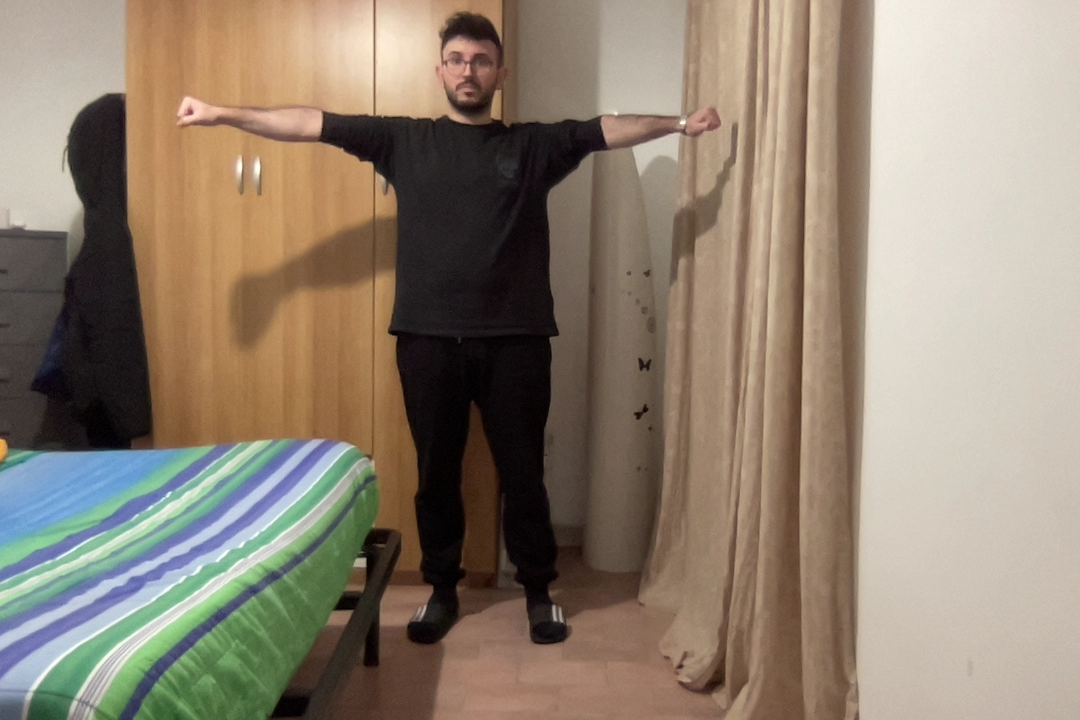

In [5]:
from IPython.display import Image
try:
  is_t_pose = False
  while not is_t_pose:
    filename = take_photo()
    if tPose(filename):
      print('Saved to {}'.format(filename))
      is_t_pose = True
    else:
      print("Please try again")
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Pifu workflow

#Automatically remove background with carvekit

In [6]:
%cd /content
!pip install carvekit_colab

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 8.0 MB/s eta 0:00:00
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31678 sha256=454ce85bd4f55e2eda14bae83727c2e96d1df7543bcf3531320076bb5b6b4363
  Stored in directory: /root/.cache/pip/

In [7]:
#@title Download all models
from carvekit.ml.files.models_loc import download_all

download_all();

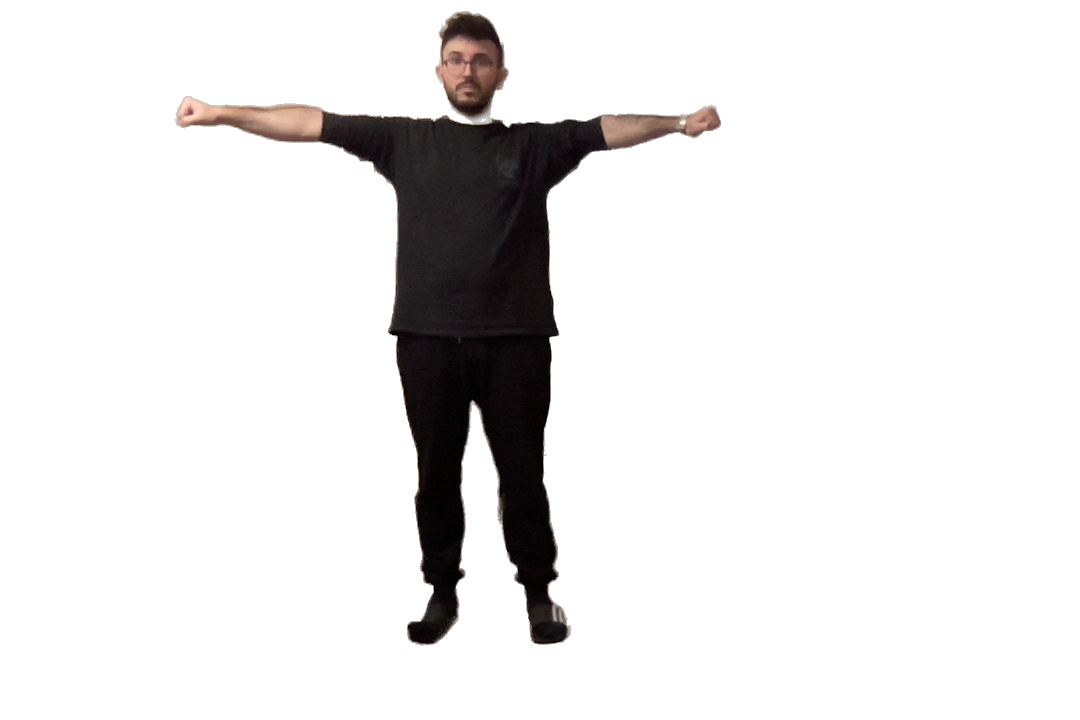

In [8]:
#@title Upload images from your computer
#@markdown Description of parameters
#@markdown - `SHOW_FULLSIZE`  - Shows image in full size (may take a long time to load)
#@markdown - `PREPROCESSING_METHOD`  - Preprocessing method
#@markdown - `SEGMENTATION_NETWORK`  - Segmentation network. Use `u2net` for hairs-like objects and `tracer_b7` for objects
#@markdown - `POSTPROCESSING_METHOD`  - Postprocessing method
#@markdown - `SEGMENTATION_MASK_SIZE` - Segmentation mask size. Use 640 for Tracer B7 and 320 for U2Net
#@markdown - `TRIMAP_DILATION`  - The size of the offset radius from the object mask in pixels when forming an unknown area
#@markdown - `TRIMAP_EROSION`  - The number of iterations of erosion that the object's mask will be subjected to before forming an unknown area
#@markdown > Look README.md and code for more details on networks and methods


import torch
import PIL
from IPython import display
from google.colab import files
from carvekit.web.schemas.config import MLConfig
from carvekit.web.utils.init_utils import init_interface

PREPROCESSING_METHOD = "stub" #@param ["stub", "none"]
SEGMENTATION_NETWORK = "tracer_b7" #@param ["u2net", "deeplabv3", "basnet", "tracer_b7"]
POSTPROCESSING_METHOD = "fba" #@param ["fba", "none"] 
SEGMENTATION_MASK_SIZE = 640 #@param ["640", "320"] {type:"raw", allow-input: true}
TRIMAP_DILATION = 30 #@param {type:"integer"}
TRIMAP_EROSION = 5 #@param {type:"integer"}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


config = MLConfig(segmentation_network=SEGMENTATION_NETWORK,
                  preprocessing_method=PREPROCESSING_METHOD,
                  postprocessing_method=POSTPROCESSING_METHOD,
                  seg_mask_size=SEGMENTATION_MASK_SIZE,
                  trimap_dilation=TRIMAP_DILATION,
                  trimap_erosion=TRIMAP_EROSION,
                  device=DEVICE)


interface = init_interface(config)
uploaded = PIL.Image.open("photo.png")
display.clear_output()
image = interface([uploaded])[0]
image.save("/content/result.png")
display.display(image)


## Clone PIFuHD repository and setup



In [15]:
#clone repository
!git clone https://github.com/facebookresearch/pifuhd
#change to sample images
%cd /content/pifuhd/sample_images

#set image paths
import os
%mv /content/result.png .
filename = "result.png"

try:
  image_path = '/content/pifuhd/sample_images/%s' % filename
except:
  image_path = '/content/pifuhd/sample_images/test.png' # example image
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output pathes
obj_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.png' % file_name
video_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/pifuhd/results/pifuhd_final/result_%s_256_display.mp4' % file_name

%cd /content

Cloning into 'pifuhd'...
remote: Enumerating objects: 213, done.
remote: Total 213 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (213/213), 402.76 KiB | 30.98 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/pifuhd/sample_images
mv: cannot stat '/content/result.png': No such file or directory
/content


## Preprocess (for cropping image)

In [10]:
!git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git
%cd /content/lightweight-human-pose-estimation.pytorch/
!wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

Cloning into 'lightweight-human-pose-estimation.pytorch'...
remote: Enumerating objects: 120, done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 120
Receiving objects: 100% (120/120), 223.40 KiB | 20.31 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/lightweight-human-pose-estimation.pytorch
--2023-01-26 11:21:48--  https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth
Resolving download.01.org (download.01.org)... 104.106.178.195, 2600:1408:c400:395::4b21, 2600:1408:c400:391::4b21
Connecting to download.01.org (download.01.org)|104.106.178.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87959810 (84M) [application/octet-stream]
Saving to: ‘checkpoint_iter_370000.pth’

checkpoint_iter_370 100%[===================>]  83.88M  97.4MB/s    in 0.9s    

2023-01-26 11:21:49 (97.4 MB/s) - ‘checkpoint_iter_370000.pth’ saved [87959810/87959810]



In [11]:
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=False)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)
            
            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(np.int)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')

In [12]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net.cuda(), [image_path], 512)

<ipython-input-11-1919f42bf24c>:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)


## Download the Pretrained Model

In [13]:
%cd /content/pifuhd/
!sh ./scripts/download_trained_model.sh

/content/pifuhd
+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt pifuhd.pt
--2023-01-26 11:21:50--  https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548375177 (1.4G) [application/octet-stream]
Saving to: ‘pifuhd.pt’

pifuhd.pt           100%[===================>]   1.44G  29.3MB/s    in 38s     

2023-01-26 11:22:28 (39.0 MB/s) - ‘pifuhd.pt’ saved [1548375177/1548375177]

--2023-01-26 11:22:28--  http://pifuhd.pt/
Resolving pifuhd.pt (pifuhd.pt)... failed: Name or service not known.
wget: unable to resolve host address ‘pifuhd.pt’
FINISHED --2023-01-26 11:22:28--
Total wall clock time: 38s
Downloaded: 1 files, 1.4G in 38s (39.0 MB/s)


## Run PIFuHD!


In [14]:
# Warning: all images with the corresponding rectangle files under -i will be processed. 
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

# seems that 256 is the maximum resolution that can fit into Google Colab. 
# If you want to reconstruct a higher-resolution mesh, please try with your own machine. 

Resuming from  ./checkpoints/pifuhd.pt
test data size:  1
initialize network with normal
initialize network with normal
generate mesh (test) ...
  0% 0/1 [00:00<?, ?it/s]./results/pifuhd_final/recon/result_result_256.obj
/content/pifuhd/lib/mesh_util.py:77: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(sdf, thresh)
100% 1/1 [00:07<00:00,  7.32s/it]


In [ ]:
#Delete previous results 

!rm -rf results
#to_remove = filename[:-4] + "*"
#os.system("rm sample_images/{}".format(filename))

# RigNet workflow

Automatically rename and remesh file

In [16]:
%cd /content

/content


## Install dependencies

In [18]:
!pip install open3d>=0.9.0
!pip install trimesh[easy]

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!apt-get install xvfb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.9/670.9 KB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 KB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.4 MB/s eta 0:00:00
  Created wheel for pycollada: filename=pycollada-0.7.2-py3-none-any.whl size=127027 sha256=e2bec6fd821356d4ff5c95893948ba2985c0b754d68423cdc5e52df3cebbead1
  Stored in directory: /root/.cache/pip/wheels/2b/ed/a0/7b81d1357498460eaf05de8081fa1054a32013d44cd7a38775
Successfully built pycollada
1.13.

In [19]:
import open3d as o3d
triangle_mesh = o3d.io.read_triangle_mesh("/content/pifuhd/results/pifuhd_final/recon/result_result_256.obj")
simplified_mesh = o3d.geometry.TriangleMesh.simplify_quadric_decimation(triangle_mesh, 1600)
o3d.io.write_triangle_mesh("result_remesh.obj",
                               simplified_mesh,
                               write_triangle_uvs=True)

True

In [20]:
%cp /content/pifuhd/results/pifuhd_final/recon/result_result_256.obj /content/result_ori.obj

## Clone RigNet fork modified to work on colab/headless server

In [21]:
%cd /content

#clone forked repo
!git clone https://github.com/bonjon/RigNet.git

#setup checkpoints
#create a folder named CV in drive and put the checkpoints here
#or simply upload and unzip it in rignet folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#%cp -r /content/drive/MyDrive/CV/trained_models/checkpoints /content/RigNet
%cp -r /content/drive/MyDrive/checkpoints /content/RigNet

/content
Cloning into 'RigNet'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 282 (delta 47), reused 42 (delta 36), pack-reused 193
Receiving objects: 100% (282/282), 4.12 MiB | 26.18 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Mounted at /content/drive


## Move PifuHD results into quickstart

In [22]:
%cp /content/result_ori.obj /content/RigNet/quick_start
%cp /content/result_remesh.obj /content/RigNet/quick_start

## Run the model

In [23]:
%cd RigNet
!python3 quick_start.py

/content/RigNet
loading all networks...
     joint prediction network loaded.
     root prediction network loaded.
     connection prediction network loaded.
     skinning prediction network loaded.
creating data for model ID result
     gathering topological edges.
     calculating surface geodesic matrix.
surface geodesic calculation: 8.499819040298462 seconds
     gathering geodesic edges.

--- [binvox] mesh voxelizer, version 1.26, build #644 on 2017/10/22 15:19:22
--- written by Patrick Min, 2004-2017

loading model file...
MeshFileIdentifier::*create_mesh_file(quick_start/result_normalized.obj)
ObjMeshFile::load(quick_start/result_normalized.obj)
2410 quick_start/result_normalized.obj
  2411 lines read
Read 1599 faces, 807 vertices.
Mesh memory use is 1320 KB (1 MB)
  Mesh::normalize, bounding box: [-0.427588, 0, -0.106987, 1] - [0.427588, 1, 0.106987, 1]
    longest length: 1
  normalization transform:
  (1) translate [0.427588, -0, 0.106987, 1], (2) scale 1, (3) translate [0, 0